<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Check nvidia devices
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Wed Aug  5 04:03:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
DETECTRON2_DATASETS = "/content/gdrive/My Drive/Projects/Windspect/code/data"
ROADDAMAGE_DATASET  = DETECTRON2_DATASETS+"/rdd2020"
! du -h "$ROADDAMAGE_DATASET/train"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
109K	/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/annotations/xmls
113K	/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/annotations
11M	/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/images
11M	/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India
5.5M	/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/Japan/images
73K	/content/gdrive/My Driv

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
#!pip install mmcv-full
! pip install mmcv-full==latest+torch1.5.0+cu101 -f https://openmmlab.oss-accelerate.aliyuncs.com/mmcv/dist/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 39.7MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
Looking in links: https://openmmlab.oss-accelerate.aliyuncs.com/mmcv/dist/index.html
     |████████████████████████████████| 18.9MB 156kB/s 
     |████████████████████████████████| 194kB 2.7MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12590 (delta 0), reused 0 (delta 0), pack-reused 12585
Receiving objects: 100% (12590/12590), 11.54 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (8644/8644), done

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True


/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


2.3.0
10.1
GCC 7.3


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

In [5]:
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2020-08-05 04:07:09--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.19
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  45.5MB/s    in 4.1s    

2020-08-05 04:07:13 (41.7 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [6]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

In [7]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

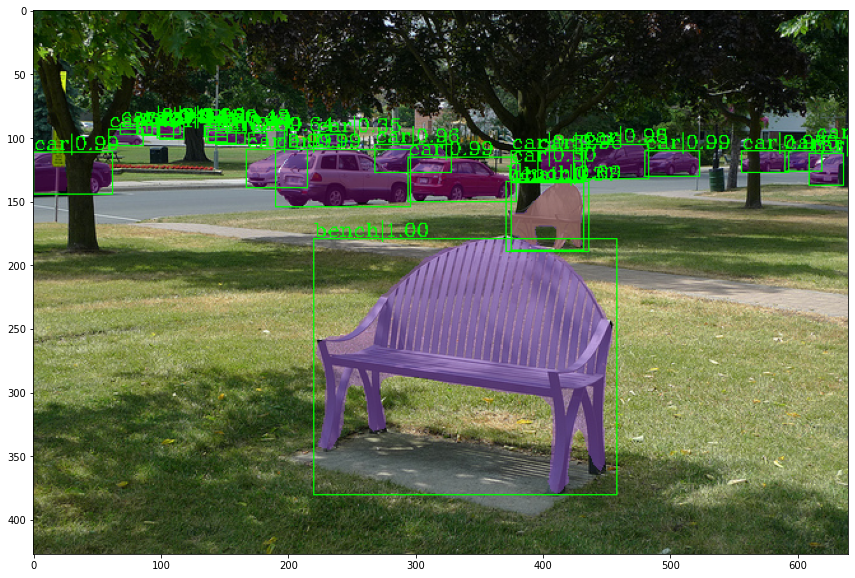

In [8]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [9]:
# Point to the dataset - https://github.com/sekilab/RoadDamageDetector/blob/master/RoadDamageDatasetTutorial.ipynb
#DETECTRON2_DATASETS = "/media/rahul/Karmic/data/"
#ROADDAMAGE_DATASET  = "../data/RoadDamageDataset/"

In [10]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree -L 2 "$ROADDAMAGE_DATASET/val"

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (41.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/val
├── Czech
│   ├── annotations
│   └── images
├── India
│   ├── annotations
│   └── images
└─

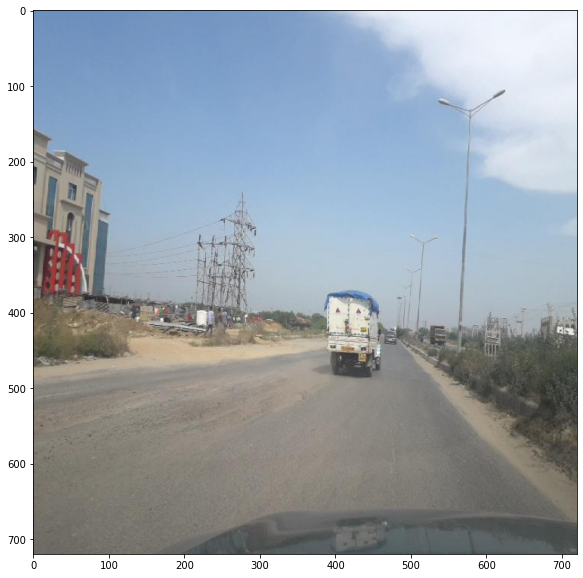

In [11]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread(ROADDAMAGE_DATASET+"/val/India/images/India_000005.jpg")
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`RDD`**.

Let's take a loot at the annotation txt file.



In [12]:
# Check the label of a single image
!cat "$ROADDAMAGE_DATASET/val/India/annotations/xmls/India_000005.xml"

<annotation>
	<folder>images</folder>
	<filename>India_000005.jpg</filename>
	<size>
		<width>720</width>
		<height>720</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>D40</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>20</xmin>
			<ymin>473</ymin>
			<xmax>368</xmax>
			<ymax>576</ymax>
		</bndbox>
	</object>
</annotation>

According to the RDD documentation. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python

```

In [13]:
import copy
import os.path as osp
import os

import mmcv
import numpy as np
from xml.etree import ElementTree
from xml.dom import minidom

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset


@DATASETS.register_module()
class RddDataset(CustomDataset):

    CLASSES = ("D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44", "D50", "D0w0")
    DATA_SUPERCATEGORY = ("Czech", "India", "Japan")

    def load_annotations(self, ann_file):
        image_id_count = 0
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file #image_list = mmcv.list_from_file(self.ann_file)
        data_infos = []
        # convert annotations to middle format
        #for idx, regions_data in enumerate(self.DATA_SUPERCATEGORY):
        regions_data = "../"
        # Assume pre-defined datasets live in `./datasets`.
        ann_path = os.path.join(self.data_root, regions_data, "annotations/xmls")
        img_path = os.path.join(self.data_root, regions_data, "images")
        print("\tLoading ", " - ", img_path, " - ", ann_path)
        # list annotations/xml dir and for each annotation load the data
        image_list = [filename for filename in os.listdir(img_path) if filename.endswith('.jpg')]
        for img_id, img_filename in enumerate(image_list):
            image_id_count = image_id_count + 1
            filename = os.path.join(img_path, img_filename)
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
            data_info = dict(filename=img_filename, width=width, height=height)
            # Load image annotations xml
            ann_filename = img_filename.split(".")[0] + ".xml"
            if os.path.isfile(os.path.join(ann_path, ann_filename)):
                infile_xml = open(os.path.join(ann_path, ann_filename))
                tree = ElementTree.parse(infile_xml)
                root = tree.getroot()
                gt_bboxes = []
                gt_labels = []
                gt_bboxes_ignore = []
                gt_labels_ignore = []
                for obj in root.iter('object'):
                    bbox_name, xmlbox = obj.find('name').text, obj.find('bndbox')
                    xmin, xmax = np.float(xmlbox.find('xmin').text), np.float(xmlbox.find('xmax').text)
                    ymin, ymax = np.float(xmlbox.find('ymin').text), np.float(xmlbox.find('ymax').text)
                    bbox = [xmin, ymin, xmax, ymax]       # (x0, y0, x1, y1)                         
                    if bbox_name in cat2label:
                        gt_labels.append(cat2label[bbox_name])
                        gt_bboxes.append(bbox)
                    else:
                        gt_labels_ignore.append(-1)
                        gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)
        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [14]:
from mmcv import Config
cfg = Config.fromfile('configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [15]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'RddDataset'
cfg.data_root = '/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/'

cfg.data.test.type = 'RddDataset'
cfg.data.test.data_root = '/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/test/India/images'
cfg.data.test.ann_file = ''
cfg.data.test.img_prefix = ''

cfg.data.train.type = 'RddDataset'
cfg.data.train.data_root = '/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/images'
cfg.data.train.ann_file = ''
cfg.data.train.img_prefix = ''

cfg.data.val.type = 'RddDataset'
cfg.data.val.data_root = '/content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/val/India/images'
cfg.data.val.ann_file = ''
cfg.data.val.img_prefix = ''

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 10
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.total_epochs = 50

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [16]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

	Loading   -  /content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/images/../images  -  /content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/train/India/images/../annotations/xmls


2020-08-05 04:11:11,632 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/checkpoints/resnet50_msra-5891d200.pth


2020-08-05 04:11:14,710 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias




	Loading   -  /content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/val/India/images/../images  -  /content/gdrive/My Drive/Projects/Windspect/code/data/rdd2020/val/India/images/../annotations/xmls


2020-08-05 04:12:21,170 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2020-08-05 04:12:21,318 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([11, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([11]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([40, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([40]).
unexpected key in source state_dict: roi_head.mask_head.co

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 54/54, 3.8 task/s, elapsed: 14s, ETA:     0s

2020-08-05 04:28:13,020 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| D00   | 11  | 48   | 0.364  | 0.054 |
| D01   | 2   | 0    | 0.000  | 0.000 |
| D10   | 0   | 0    | 0.000  | 0.000 |
| D11   | 4   | 0    | 0.000  | 0.000 |
| D20   | 9   | 93   | 0.889  | 0.290 |
| D40   | 32  | 192  | 0.531  | 0.188 |
| D43   | 0   | 0    | 0.000  | 0.000 |
| D44   | 6   | 18   | 0.333  | 0.125 |
| D50   | 0   | 0    | 0.000  | 0.000 |
| D0w0  | 0   | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.110 |
+-------+-----+------+--------+-------+
2020-08-05 04:28:13,024 - mmdet - INFO - Epoch [12][81/81]	lr: 2.500e-05, mAP: 0.1095
2020-08-05 04:28:24,755 - mmdet - INFO - Epoch [13][10/81]	lr: 2.500e-05, eta: 0:22:57, time: 1.122, data_time: 0.225, memory: 2362, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0098, loss_cls: 0.0606, acc: 98.4277, loss_bbox: 0.0595, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 54/54, 3.8 task/s, elapsed: 14s, ETA:     0s

2020-08-05 04:44:05,524 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| D00   | 11  | 43   | 0.364  | 0.065 |
| D01   | 2   | 0    | 0.000  | 0.000 |
| D10   | 0   | 0    | 0.000  | 0.000 |
| D11   | 4   | 0    | 0.000  | 0.000 |
| D20   | 9   | 82   | 0.778  | 0.362 |
| D40   | 32  | 161  | 0.500  | 0.184 |
| D43   | 0   | 0    | 0.000  | 0.000 |
| D44   | 6   | 20   | 0.333  | 0.131 |
| D50   | 0   | 0    | 0.000  | 0.000 |
| D0w0  | 0   | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.124 |
+-------+-----+------+--------+-------+
2020-08-05 04:44:05,527 - mmdet - INFO - Epoch [24][81/81]	lr: 2.500e-05, mAP: 0.1235
2020-08-05 04:44:17,201 - mmdet - INFO - Epoch [25][10/81]	lr: 2.500e-05, eta: 0:07:32, time: 1.119, data_time: 0.223, memory: 2362, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0059, loss_cls: 0.0516, acc: 98.5352, loss_bbox: 0.0733, los

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

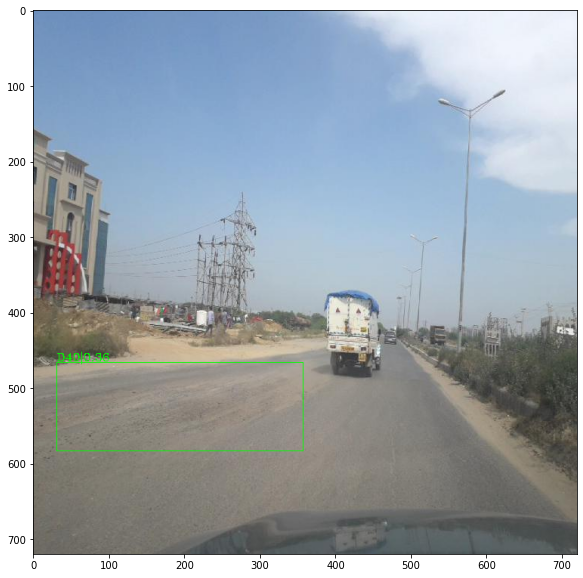

In [17]:
img = mmcv.imread(ROADDAMAGE_DATASET+"/val/India/images/India_000005.jpg")
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [18]:
print(result)

[array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[3.0723996e+02, 5.0903293e+02, 6.3971875e+02, 6.5118701e+02,
        8.3330035e-02],
       [4.6190434e+01, 5.1291272e+02, 3.5194092e+02, 7.0325800e+02,
        7.7932045e-02],
       [4.6762150e+01, 5.0391504e+02, 6.6098029e+02, 6.8587842e+02,
        6.4027518e-02]], dtype=float32), array([[3.12790909e+01, 4.66749939e+02, 3.57301361e+02, 5.83522217e+02,
        3.56463373e-01],
       [6.55753279e+00, 4.94583496e+02, 1.58864426e+02, 5.67553345e+02,
        1.30124614e-01],
       [1.72357513e+02, 4.89532135e+02, 2.07253632e+02, 5.11886444e+02,
        1.00670174e-01],
       [1.65710297e+02, 4.71680176e+02, 3.38933411e+02, 5.68769531e+02,
        9.62953046e-02],
       [1.09104805e+01, 4.84381409e+02, 2.36376282e+02, 5.95872620e+02,
        7.71728531e-02],
       [1.68444275e+02, 4.85167694e+02, 2.29497604e+02, 5.076